In [1]:
import cv2
import sklearn.cluster
import sklearn.neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.ImageColor
import scipy.spatial
import os
os.chdir('K:/ecole/github/reverse engineering')

&nbsp;
### Functions
&nbsp;

In [2]:
#get distance between a point and a line
def get_distance(x,y,a,b):
    
    temp1=y-x*a-b
    temp2=(a**2+1)**0.5
    
    return np.abs(temp1/temp2)

In [3]:
#create line equation from two points
def get_line_params(x1,y1,x2,y2):
    
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    
    return a,b

In [4]:
#knee method to determine the optimal eps for dbscan
#details can be found in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/dbscan.ipynb
def knee_method(X,num_of_neighbors,**kwargs):        
    
    #compute knn distance
    clf=sklearn.neighbors.NearestNeighbors(n_neighbors=num_of_neighbors,**kwargs)
    clf.fit(X)
    knn,_=clf.kneighbors(X)
    knn_distance=np.sort(knn, axis=0)[:,1]

    #compute perpendicular distance 
    a,b=get_line_params(0,knn_distance[0],len(knn_distance)-1,knn_distance[-1])
    distance=[]
    for i in range(len(knn_distance)):    
        distance.append(get_distance(i,knn_distance[i],a,b))
    
    return knn_distance[distance.index(max(distance))]

In [5]:
#reshape np array for unsupervised learning
def RGB2ARR(img):    

    resolutions=list(img.shape)
    col=1
    while resolutions:
        col*=resolutions.pop()
    arr=img.reshape(int(col/len(img.shape)),len(img.shape))
    
    return arr

In [6]:
#input should be np array of image
#use dbscan to identify the optimal color filter
def dbscan_color_filter(img,minpts=None,epsilon=None,
                        ordering=False,save_img=False,**kwargs):
    
    #reshape np array for unsupervised learning
    arr=RGB2ARR(img)
    
    #if minpts is not provided
    if not minpts:
        
        #minimum number for a cluster is determined by 
        #the minimum number of a unique pixel
        minpts=float('inf')
        for i in np.unique(arr,axis=0):
            if len(arr[arr==i])<minpts:
                minpts=len(arr[arr==i])
    
    #use optics
    if ordering:
        max_epsilon=scipy.spatial.distance_matrix(np.unique(arr,axis=0),
                              np.unique(arr,axis=0)).max()
        clf=sklearn.cluster.OPTICS(min_samples=minpts,
                                   max_eps=max_epsilon,**kwargs)

    else:
        
        #use knee method to determine eps
        if not epsilon:
            clf=sklearn.cluster.DBSCAN(min_samples=minpts,
                                       eps=knee_method(arr,
                                                       minpts),
                                       **kwargs)
        else:
            clf=sklearn.cluster.DBSCAN(min_samples=minpts,
                                       eps=epsilon,
                                       **kwargs)
            
    forecast=clf.fit_predict(arr)
                          
    #get filtered images
    masque={}
    for i in set(forecast):
        masque[i]=np.zeros(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).shape)
        labels=forecast.reshape(masque[i].shape)
        masque[i][labels==i]=255
        
        #export filtered image
        if save_img:
            cv2.imwrite(f"channel {i}.png",masque[i]) 

    return masque

In [7]:
#input should be np array of image
#use np array index to approximate actual coordinates
def read_xy_from_pixels(target,xmax,xmin,ymax,ymin,
                        vert_flip=False):
    
    output=[]
    
    matrix=target.copy()
    
    #vertically flip the image
    if vert_flip:        
        matrix=np.flip(target,axis=0)
    
    #convert resolution to the scale of axis
    yfactor=(ymax-ymin)/matrix.shape[0]
    xfactor=(xmax-xmin)/matrix.shape[1]
    
    #capture the curve
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j]!=0:
                output.append((xmin+j*xfactor,ymin+i*yfactor))
    
    return sorted(output)

In [8]:
#create clean dataframe from line chart
#remove duplicate values
def clean_df_line(target):

    df=pd.DataFrame(target)
    
    #use mean for different y values given the same x
    temp=[]
    for i in df[0].unique():
        temp.append((i,df[1][df[0]==i].mean()))

    df=pd.DataFrame()

    df['x']=[i[0] for i in temp]
    df['y']=[i[1] for i in temp]

    return df

In [9]:
#create clean dataframe from bar chart
#remove duplicate values
def clean_df_bar(target,remove_y_dup=False):

    df=pd.DataFrame(target)
    
    #use max for different y values given the same x
    temp=[]
    for i in df[0].unique():
        temp.append((i,df[1][df[0]==i].max()))

    df=pd.DataFrame()

    df['x']=[i[0] for i in temp]
    df['y']=[i[1] for i in temp]
    
    #remove y duplicates
    if remove_y_dup:
        df=df.loc[df['y'].drop_duplicates().index]
    
    df.reset_index(inplace=True,drop=True)
    
    return df

In [10]:
#convert size of pixels to size of data
def shrink_data_size(data,xaxis,mae=False):
    
    if not mae:
        
        output=data[0::len(data)//len(xaxis)]
        
        if len(output)==len(xaxis):
            return output
        else:
            return output.iloc[:len(xaxis)]
    
    else:
        
        #due to the cluster of the pixels
        #a double colon slicing may not be a good idea
        #use minimum absolute error of x axis
        indices=[(data['x']-i).apply(abs).idxmin() for i in xaxis]

        return data.loc[indices]    

In [11]:
#dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)
    
    #plot 1st
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2 = ax.twinx()

    #plot 2nd
    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

&nbsp;
### Bar Chart
&nbsp;

In [12]:
#the image comes from my epidemic outbreak project
#remove title, legend, labels, axis
#the original image is in the following link
# https://github.com/je-suis-tm/graph-theory/blob/master/Epidemic%20Outbreak%20project/preview/graph-degree%20distribution.png
#the modified image is in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/Reverse%20Engineering%20project/preview/bar%20chart.png
img_bar=cv2.imread('viz.png',1)

In [13]:
#use knee method to separate color channels
masque_bar=dbscan_color_filter(img_bar,minpts=None,epsilon=None,
                               ordering=False,save_img=False)

#unfortunately we cannot obtain a proper eps from knee method
#cuz the pixels form a sparse distance matrix

ValueError: eps must be positive.

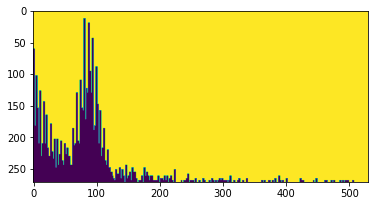

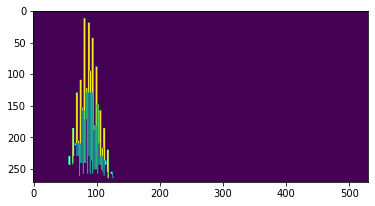

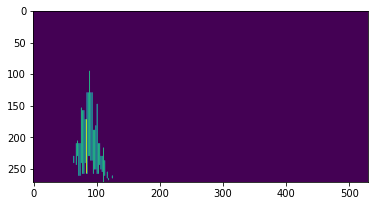

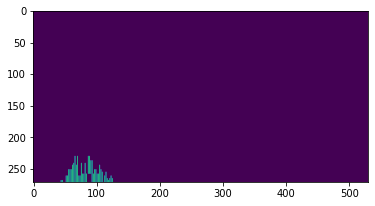

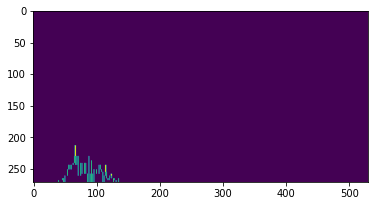

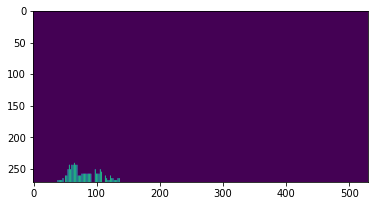

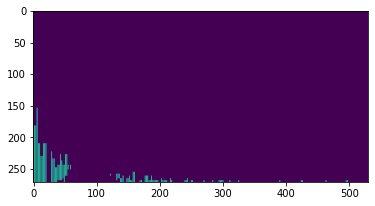

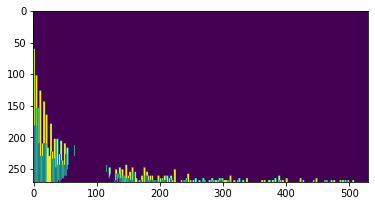

In [14]:
#use optics
masque_bar=dbscan_color_filter(img_bar,minpts=None,epsilon=None,
                               ordering=True,save_img=True)

#similar to gmm, almost all the unique colors form a cluster
for i in masque_bar:
    plt.imshow(masque_bar[i])
    plt.show()

In [15]:
#really struggle to find eps to create three clusters

&nbsp;
### Line Chart
&nbsp;

In [16]:
#the image comes from my smart farmer project
#remove title, legend, labels, axis
#the original image is in the following link
# https://github.com/je-suis-tm/quant-trading/blob/master/Smart%20Farmers%20project/preview/oil%20palm%20vs%20palm%20oil.png
#the modified image is in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/Reverse%20Engineering%20project/preview/line%20chart.png
img_line=cv2.imread('viz2.png',1)

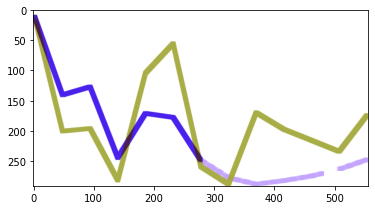

In [17]:
#connect dotted line via erosion
erosion_dotted=cv2.erode(img_line,np.ones((7,7),'uint8'),iterations=1)
cv2.imwrite("erosion1.png",erosion_dotted)

plt.imshow(erosion_dotted)

In [18]:
#use knee method to separate color channels
masque_line=dbscan_color_filter(erosion_dotted,minpts=None,epsilon=None,
                               ordering=False,save_img=True)

#unfortunately memory error
#there are too many unique pixels in the image
#we can only distinguish 4 from the image but there are 686
for i in masque_line:
    plt.imshow(masque_line[i])
    plt.show()

MemoryError: 

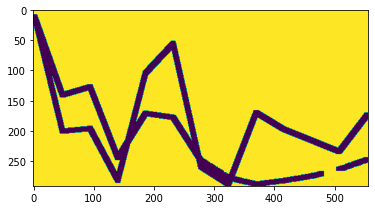

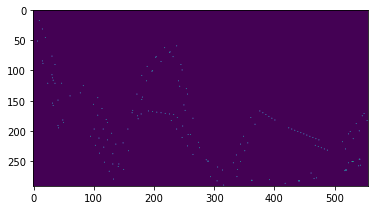

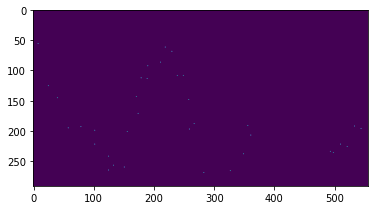

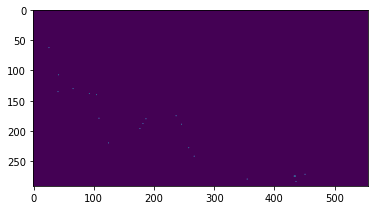

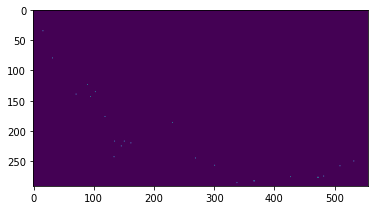

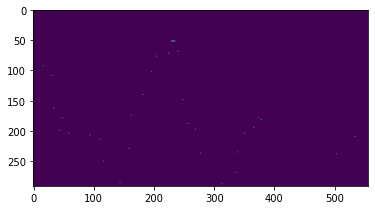

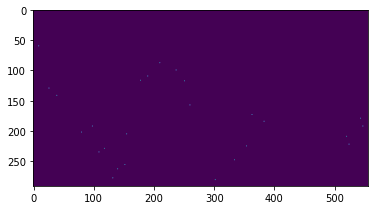

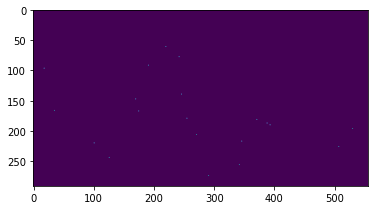

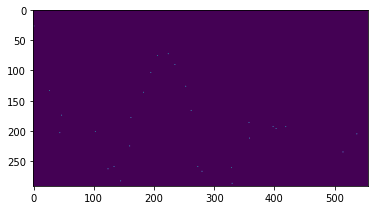

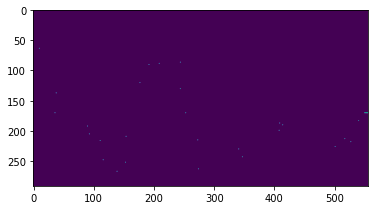

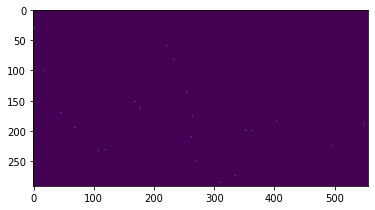

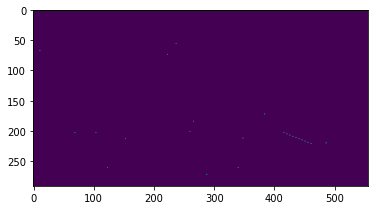

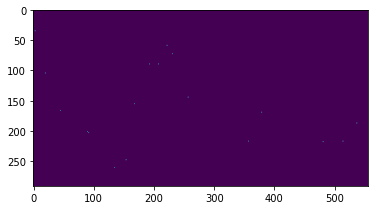

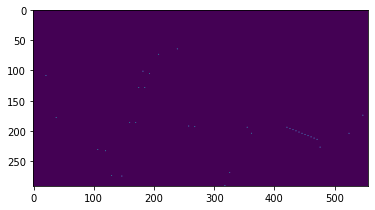

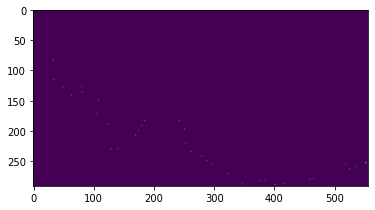

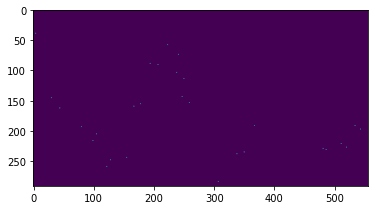

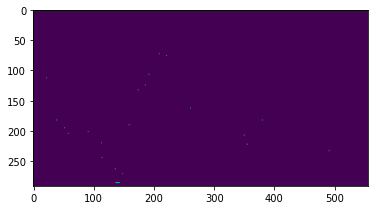

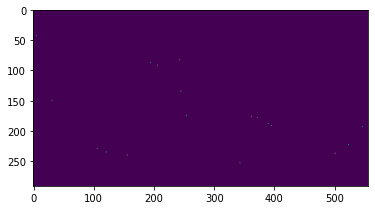

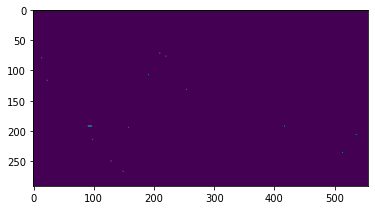

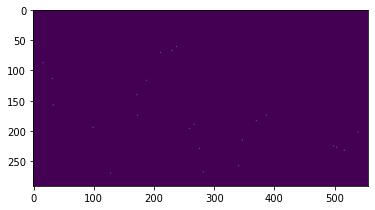

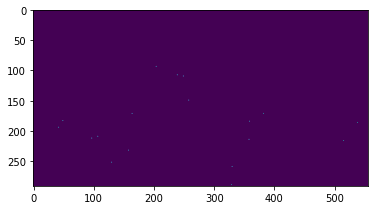

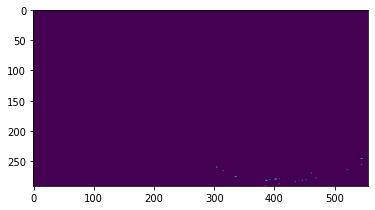

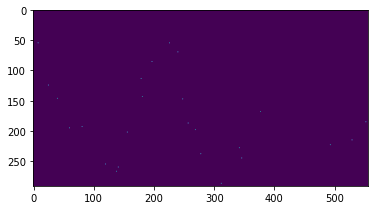

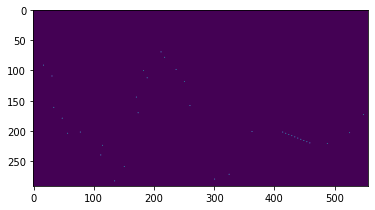

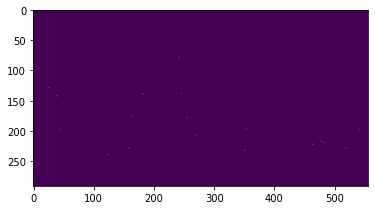

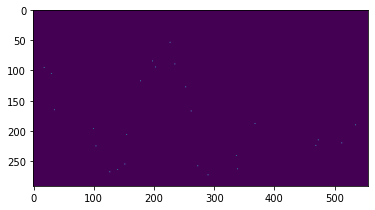

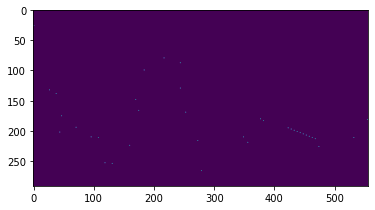

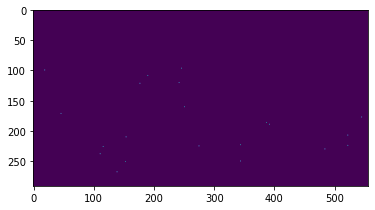

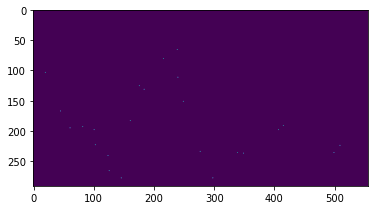

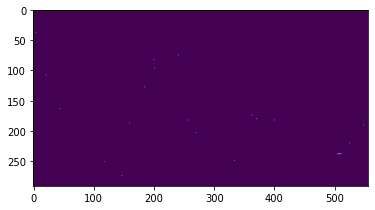

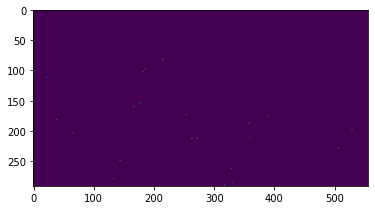

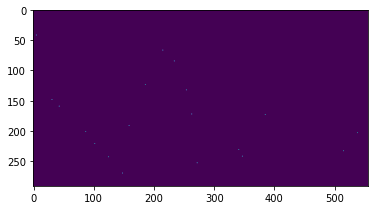

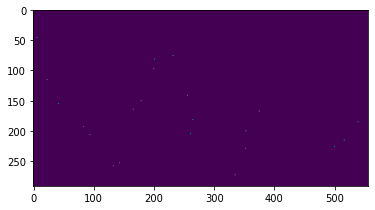

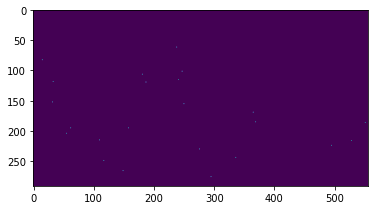

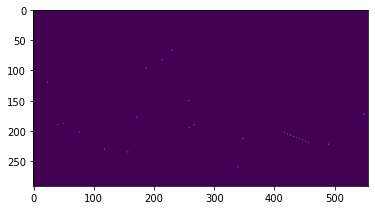

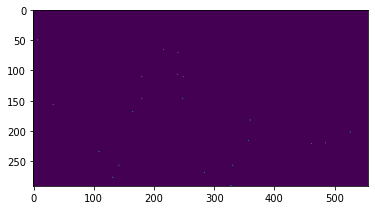

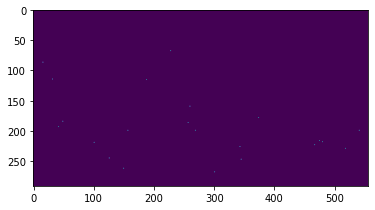

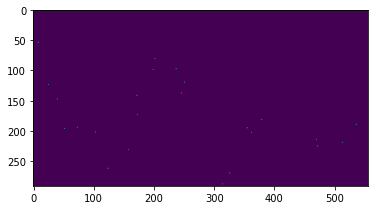

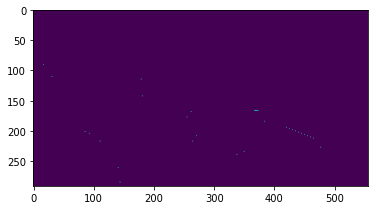

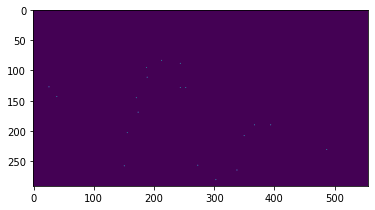

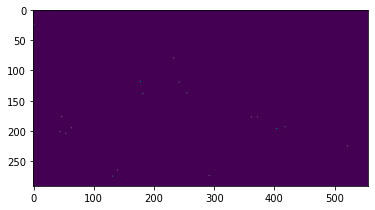

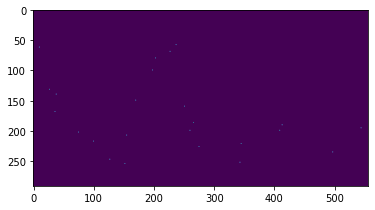

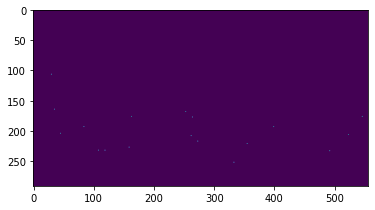

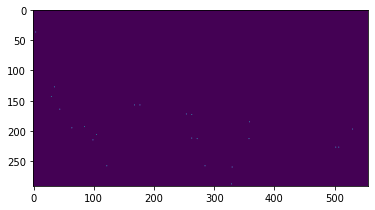

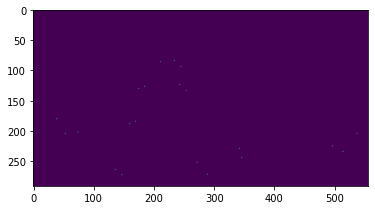

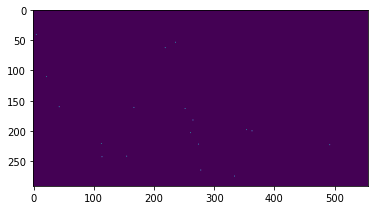

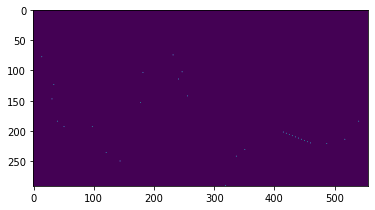

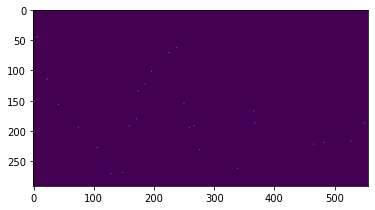

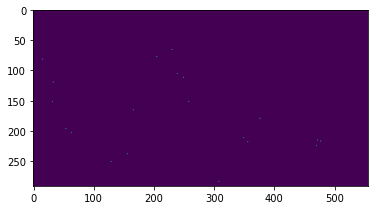

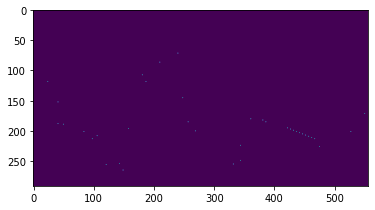

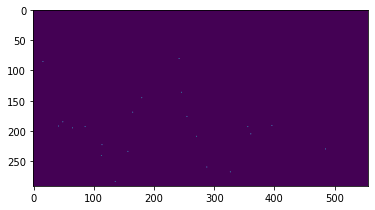

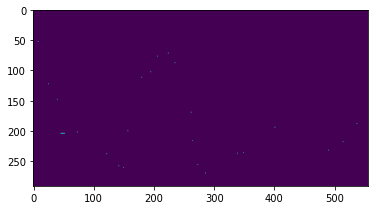

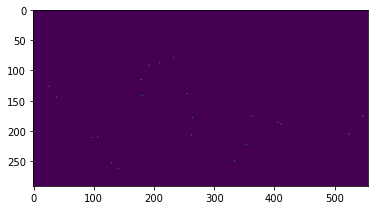

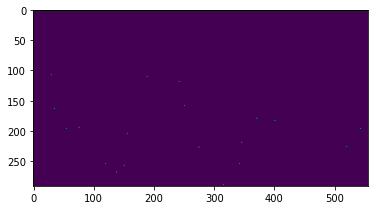

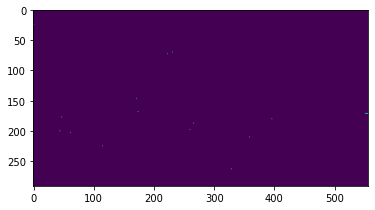

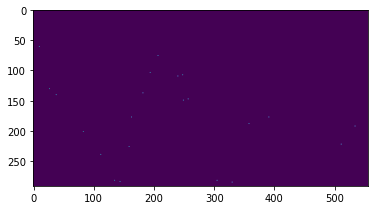

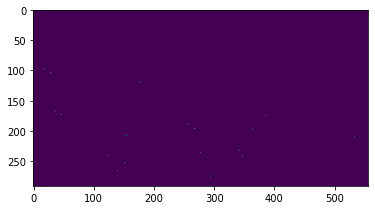

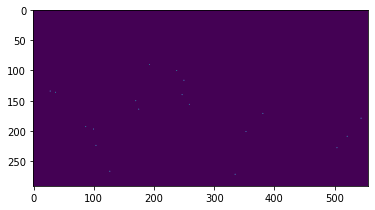

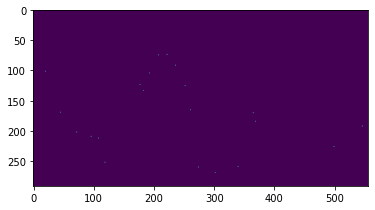

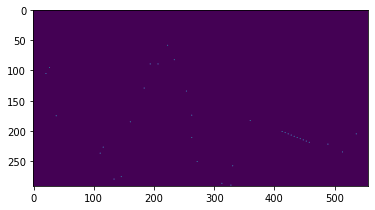

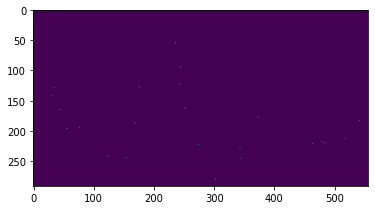

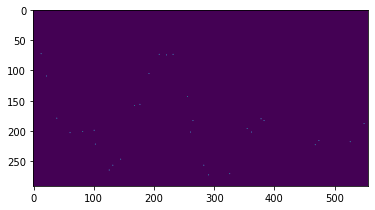

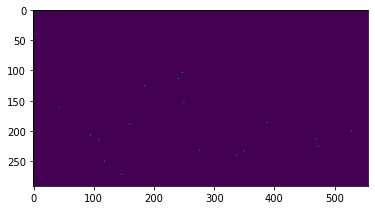

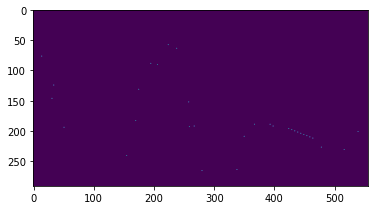

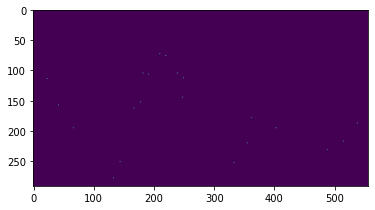

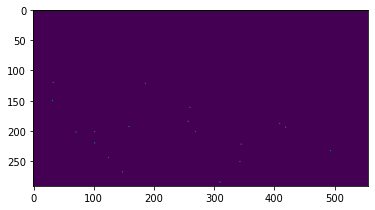

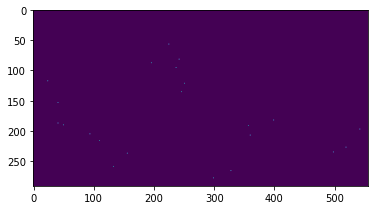

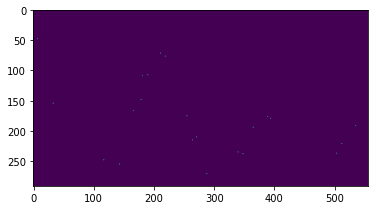

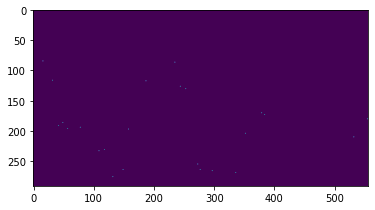

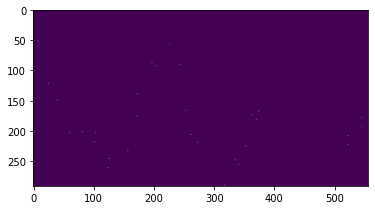

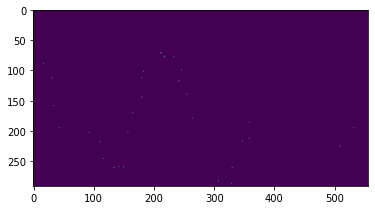

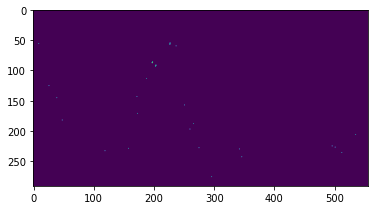

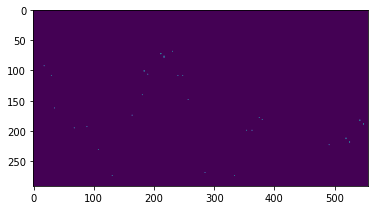

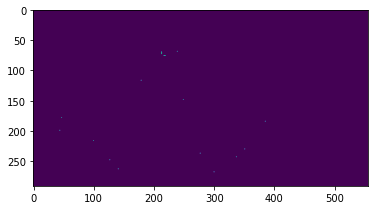

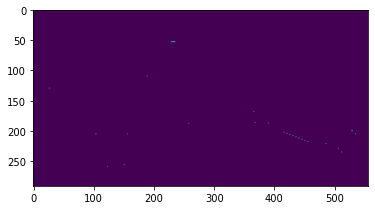

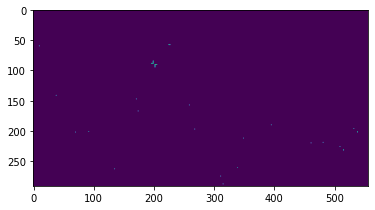

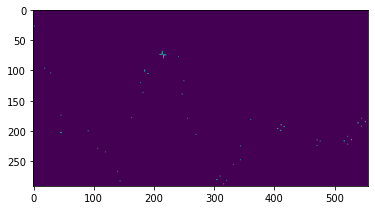

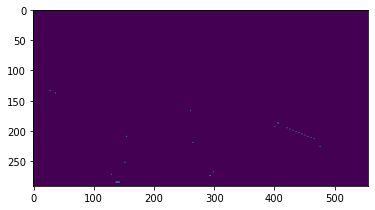

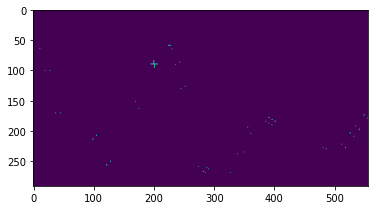

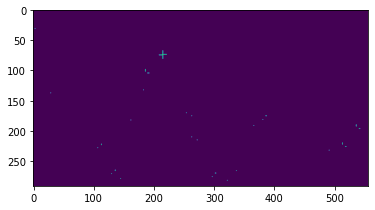

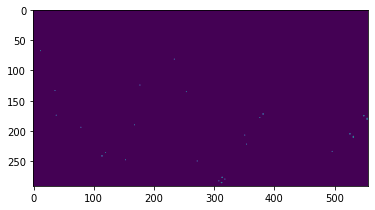

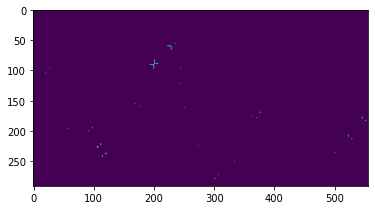

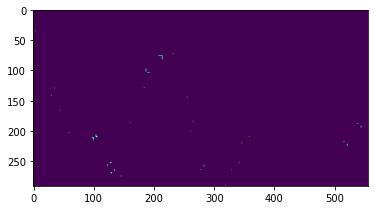

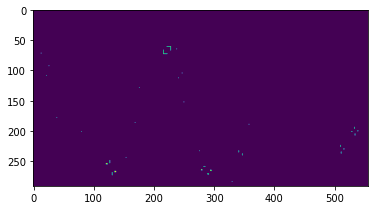

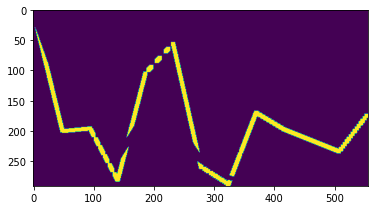

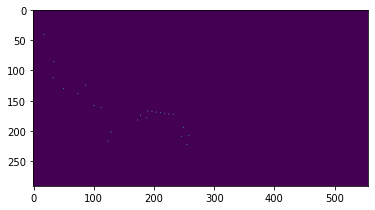

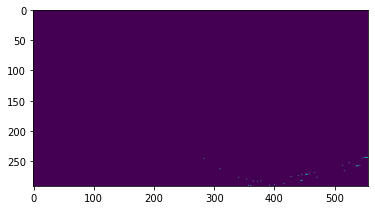

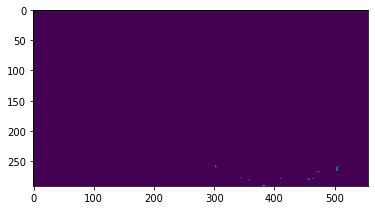

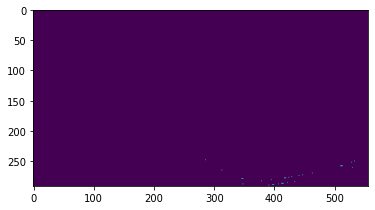

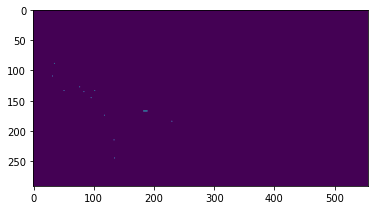

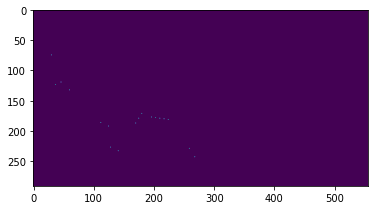

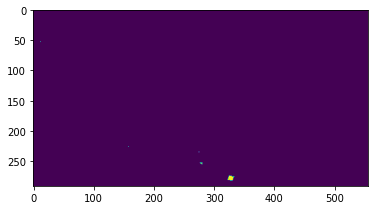

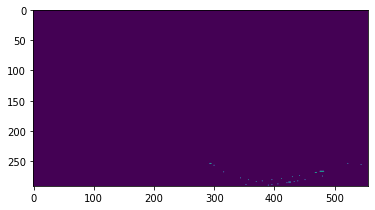

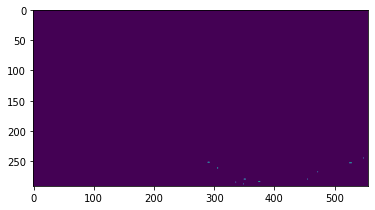

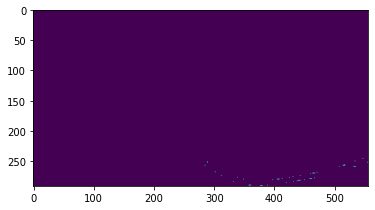

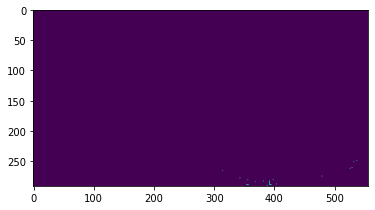

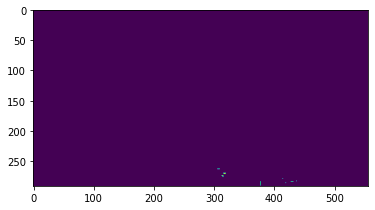

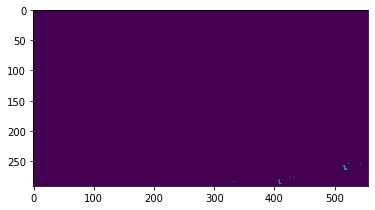

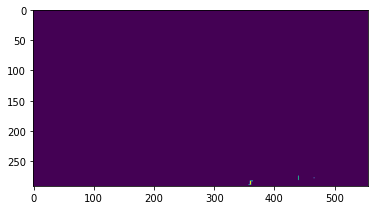

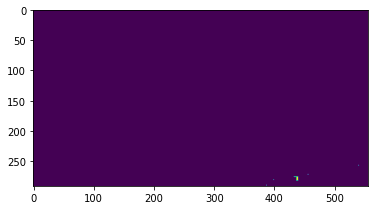

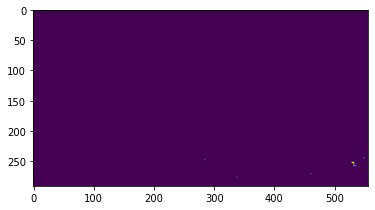

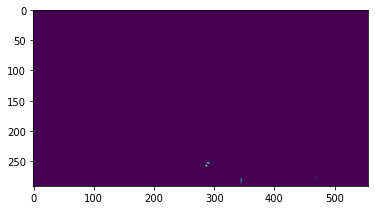

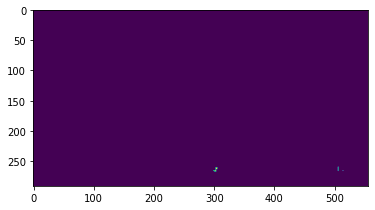

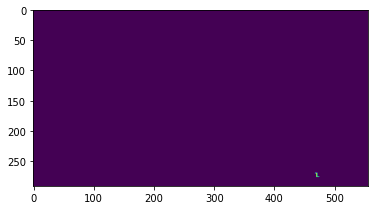

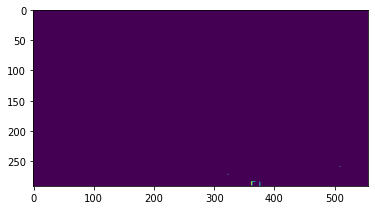

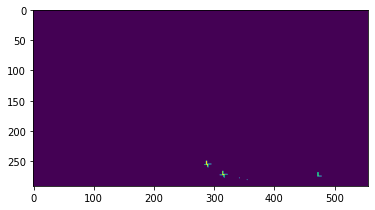

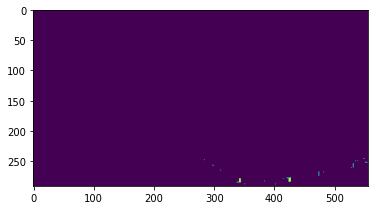

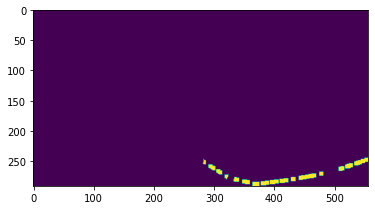

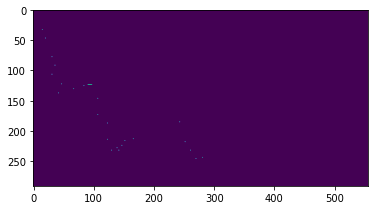

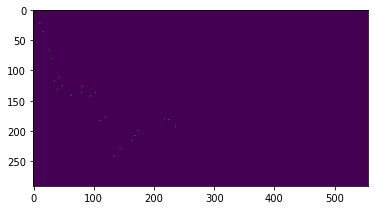

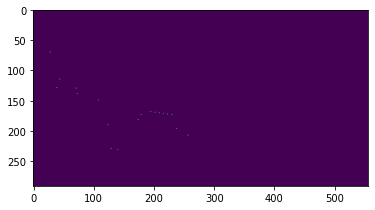

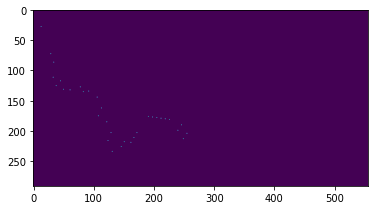

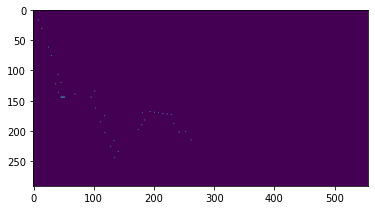

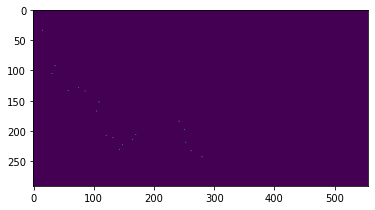

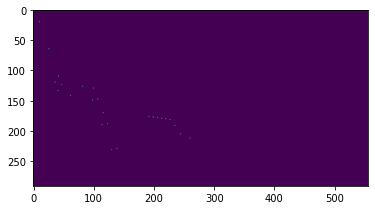

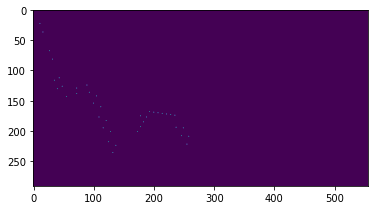

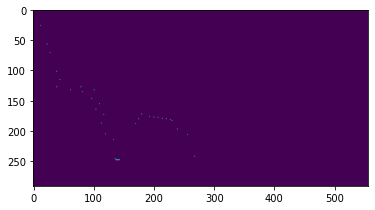

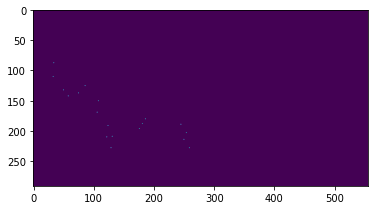

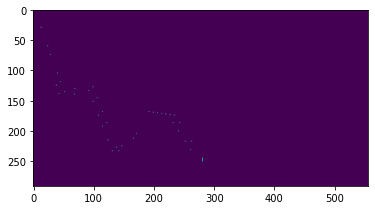

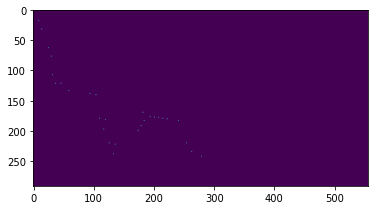

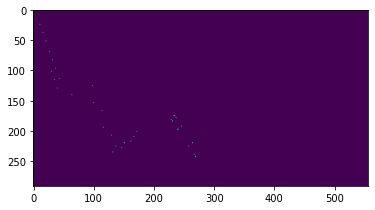

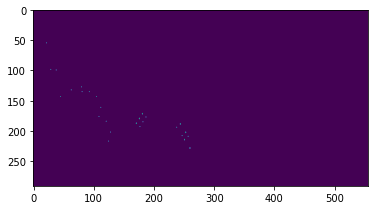

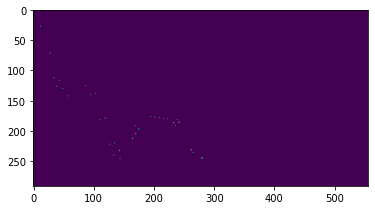

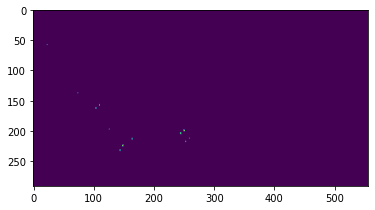

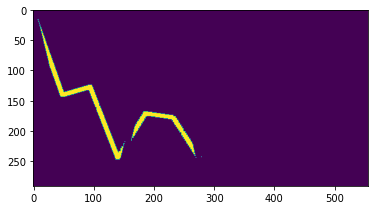

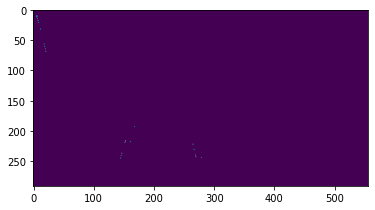

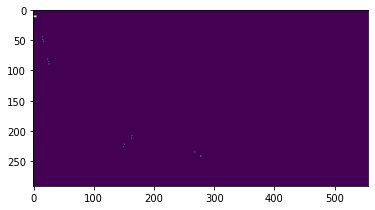

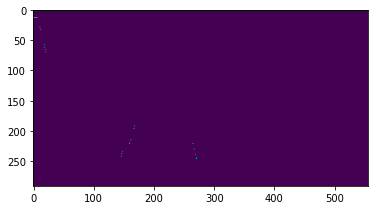

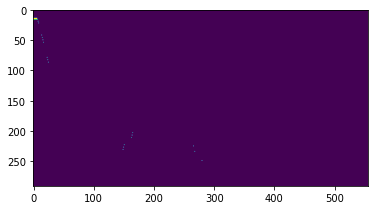

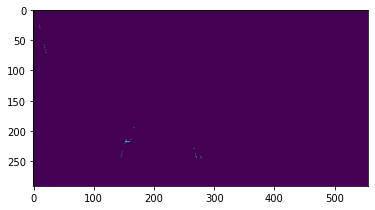

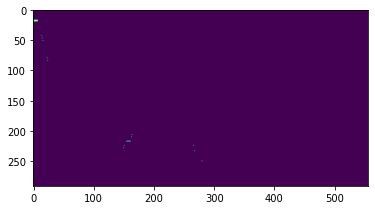

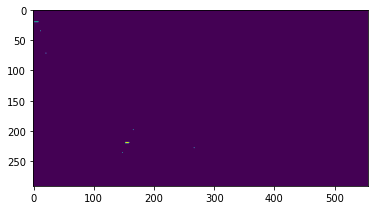

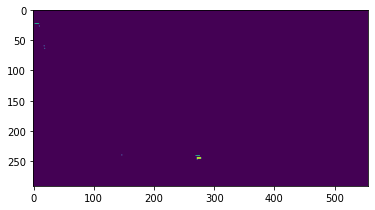

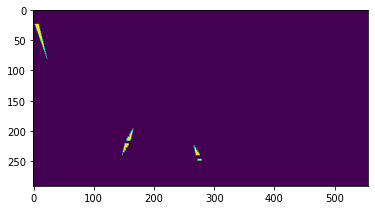

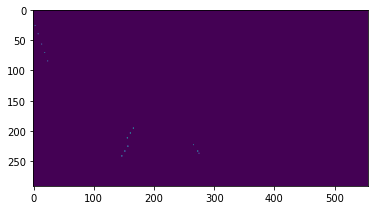

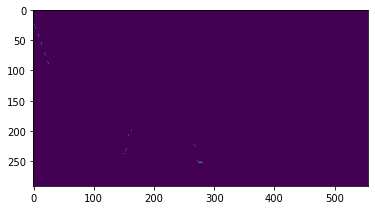

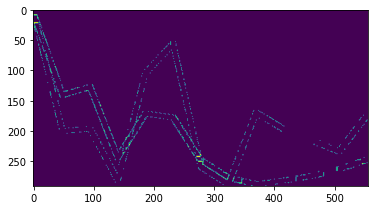

In [19]:
#use knee method to separate color channels
masque_line=dbscan_color_filter(erosion_dotted,minpts=None,epsilon=None,
                               ordering=True,save_img=True)

#for some unknown reason, 137 clusters are identified
for i in masque_line:
    plt.imshow(masque_line[i])
    plt.show()

In [20]:
#really struggle to find eps to create four clusters